# Time Series Forecasting With Prophet

[Prophet](https://facebookincubator.github.io/prophet/) is an open source forecasting tool built by Facebook.  It can be used for time series modeling and forcasting trends into the future.  Prophet is interesting because it's both sophisticated and quite easy to use, so it's possible to generate very good forecasts with relatively little effort or domain knowledge in time series analysis.

There are a few requirements you'll need to meet in order to use the library.  It uses PyStan to do all of its inference, so PyStan has to be installed.  PyStan has its own dependencies, including a C++ compiler.  Python 3 also appears to be a requirement.  Full installation instrutions are [here](https://facebookincubator.github.io/prophet/docs/installation.html).

Let's take a quick tour through Prophet's capabilities.  We can start by reading in some sample time series data.  In this case we're using Wikipedia page hits for Peyton Manning, which is the data set that Facebook collected for the library's example code.

In [1]:
%matplotlib inline
import os
import pandas as pd
import numpy as np
from fbprophet import Prophet

path = os.path.dirname(os.path.dirname(os.getcwd())) + '/data/manning.csv'
data = pd.read_csv(path)
data['ds'] = pd.to_datetime(data['ds'])
data.head()

,ds,y
0,2007-12-10,14629
1,2007-12-11,5012
2,2007-12-12,3582
3,2007-12-13,3205
4,2007-12-14,2680


There are only two columns in the data, a date and a value.  The naming convention of using 'ds' for the date and 'y' for the value is apparently a requirement to use Prophet; it's expecting those exact names and will not work otherwise!

Let's examine the data by plotting it using pandas' built-in plotting function.

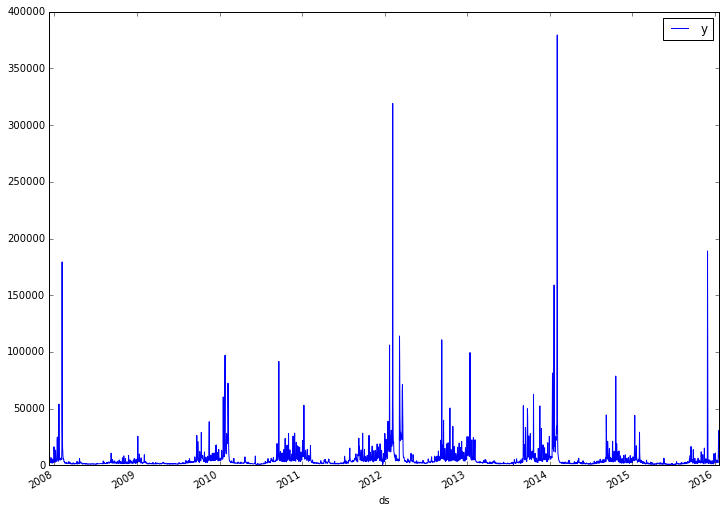

In [2]:
data.set_index('ds').plot(figsize=(12, 9))

The data is highly volatile with order-of-magnitude differences between a typical day and a high-traffic day.  This will be hard to model directly.  Let's try applying a log transform to see if that helps.

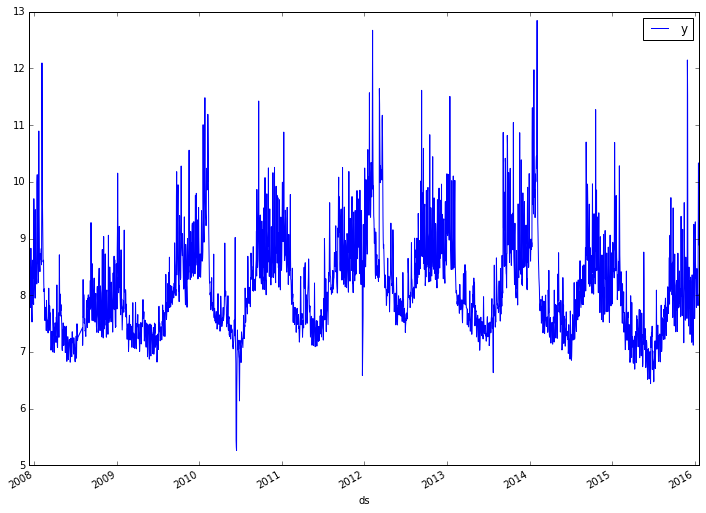

In [3]:
data['y'] = np.log(data['y'])
data.set_index('ds').plot(figsize=(12, 9))

Much better!  Not only is it stationary, but we've also revealed what looks like some cyclical patterns in the data.  We can now instantiate a Prophet model and fit it to our data.

In [4]:
m = Prophet()
m.fit(data)

That was easy!  This is one of the most attractive features of Prophet.  It essentially does all of the model selection work for you and gives you a result that works well without much user input required.  In this case we didn't have to specify anything at all, just give it some data and we get a model.

We'll explore below what the model looks like but it's worth spending a moment first to explain what's going on here.  Unlike typical time-series methods like ARIMA (which are considered generative models), Prophet uses something called an additive regression model.  This is essentially a sophisticated curve-fitting model.  I haven't dug into any of the math, but based on the description in their [introductory blog post](https://research.fb.com/prophet-forecasting-at-scale/), Prophet builds separate components for the trend, yearly seasonality, and weekly seasonality in the time series (with holidays as an optional fourth component).  We can witness this directly by looking at one of the undocumented properites on the model object that shows the fitted parameters.

In [5]:
m.params

{u'beta': array([[ 0.        , -0.03001147,  0.04819977,  0.00999481, -0.00228437,
          0.01252909,  0.01559136,  0.00950633,  0.00075704,  0.00391209,
         -0.00586589,  0.0075454 , -0.00524287,  0.00208091, -0.00477578,
         -0.00410379, -0.0077744 , -0.00081338,  0.00125811,  0.00187115,
          0.0069828 , -0.01233829, -0.01057246,  0.00938595,  0.00847051,
          0.00088024, -0.00352237]]),
 u'delta': array([[  1.62507395e-07,   1.29092081e-08,   3.48169254e-01,
           4.57815903e-01,   1.61826714e-07,  -5.66144938e-04,
          -2.34969389e-01,  -2.46905754e-01,   9.96595883e-08,
          -1.82605683e-07,   6.12381739e-08,   2.78653912e-01,
           2.30631082e-01,   2.83118248e-03,   1.55276178e-03,
          -8.61134360e-01,  -3.14239669e-07,   5.54456073e-09,
           4.91423429e-07,   4.71475093e-01,   7.93935609e-03,
           1.36547372e-07,  -3.38274613e-01,  -3.20008088e-07,
           1.16410210e-07]]),
 u'gamma': array([[ -5.37486490e-09,  -

I think the beta, delta, and gamma arrays correspond to the distributions for the three different components.  The way I think about this is we're saying we have three different regression models with some unknown set of parameters, and we want to find the combination of those models that best explains the data.  We can attempt to do this using maximum a-priori (MAP) estimation, where our priors are the equations for the regression components (piecewise linear for the trend, Fourier series for the seasonal component, and so on).  This appears to be what Prophet is doing.  I can't say I've looked at it in any great detail so part of that explanation could be wrong, but I think it's broadly correct.

Now that we have a model, let's see what we can do with it.  The obvious place to start is to forecast what we think our value will be for some future dates.  Prophet makes this easy with a helper function.

In [6]:
future_data = m.make_future_dataframe(periods=365)
future_data.tail()

,ds
3265,2017-01-15
3266,2017-01-16
3267,2017-01-17
3268,2017-01-18
3269,2017-01-19


That gives us a data frame with dates going one year forward from where our data ends.  We can then use the "predict" function to populate this data frame with forecast information.

In [7]:
forecast = m.predict(future_data)
forecast.columns

Index([u'ds', u't', u'trend', u'seasonal_lower', u'seasonal_upper',
       u'trend_lower', u'trend_upper', u'yhat_lower', u'yhat_upper', u'weekly',
       u'weekly_lower', u'weekly_upper', u'yearly', u'yearly_lower',
       u'yearly_upper', u'seasonal', u'yhat'],
      dtype='object')

The point estimate forecasts are in the "yhat" column, but note how many columns got added.  In addition to the forecast itself we also have point estimates for each of the components, as well as upper and lower bounds for each of these projections.  That's a lot of detail provided out-of-the-box just by calling a single function!

Let's see an example.

In [8]:
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
3265,2017-01-15,8.200620,7.493151,8.886727
3266,2017-01-16,8.525638,7.791967,9.266697
3267,2017-01-17,8.313019,7.620597,9.000529
3268,2017-01-18,8.145577,7.449701,8.870133
3269,2017-01-19,8.157476,7.467178,8.860933


Prophet also supplies several useful plotting functions.  The first one is just called "plot", which displays the actual values along with the estimates.  For the forecast period it only displays the projections since we don't have actual values for this period.

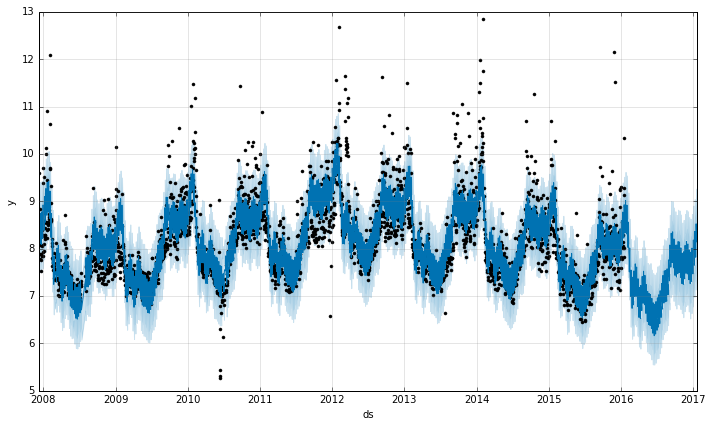

In [9]:
m.plot(forecast);

I found this to be a bit confusing because the data frame we passed in only contained the "forecast" date range, so where did the rest of it come from?  I think the model object is storing the data it was trained on and using it as part of this function, so it looks like it will plot the whole date range regardless.

We can use another built-in plot to show each of the individual components.  This is quite useful to visually inspect what the model is capturing from the data.  In this case there are a few clear takeaways such as higher activity during football season or increased activity on Sunday & Monday.

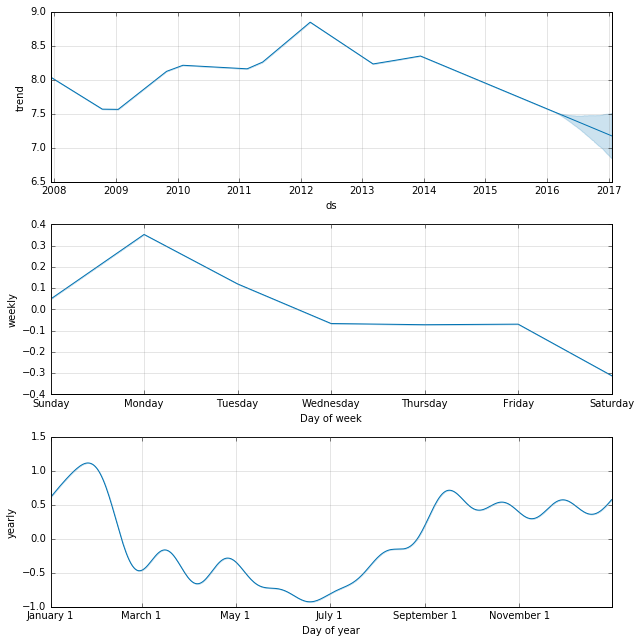

In [10]:
m.plot_components(forecast);

In addition to the above components, Prophet can also incorporate possible effects from holidays.  Holidays and dates for each holiday have to be manually specificed over the entire range of the data set (including the forecast period).  The way holidays get defined and incorporated into the model is fairly simple.  Below are some holiday definitions for our current data set that include Peyton Manning's playoff and superbowl appearances (taken from the example code).

In [11]:
playoffs = pd.DataFrame({
  'holiday': 'playoff',
  'ds': pd.to_datetime(['2008-01-13', '2009-01-03', '2010-01-16',
                        '2010-01-24', '2010-02-07', '2011-01-08',
                        '2013-01-12', '2014-01-12', '2014-01-19',
                        '2014-02-02', '2015-01-11', '2016-01-17',
                        '2016-01-24', '2016-02-07']),
  'lower_window': 0,
  'upper_window': 1,
})

superbowls = pd.DataFrame({
  'holiday': 'superbowl',
  'ds': pd.to_datetime(['2010-02-07', '2014-02-02', '2016-02-07']),
  'lower_window': 0,
  'upper_window': 1,
})

holidays = pd.concat((playoffs, superbowls))

Once we have holidays defined in a data frame, using them in the model is just a matter of passing in the data frame as a parameter when we define the model.

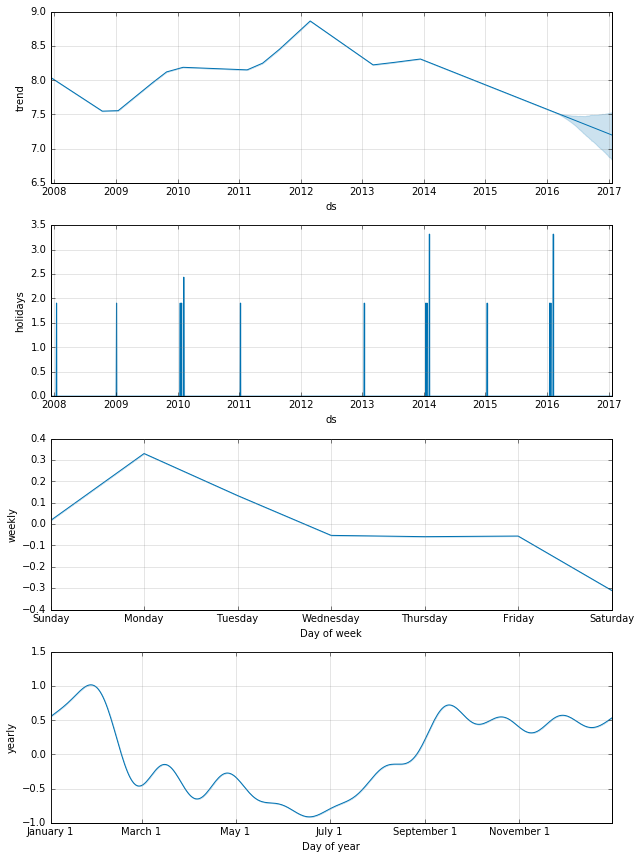

In [12]:
m = Prophet(holidays=holidays)
forecast = m.fit(data).predict(future_data)
m.plot_components(forecast);

Our component plot now includes a holidays component with spikes indicating the magnitude of influence those holidays have on the value.

While the Prophet library itself is very powerful, there are some useful features that we'd typically want when doing time series modeling that it currently doesn't provide.  One very simple and obvious thing that's needed is a way to evaluate the forecasts.  We can do this ourselves using scikit-learn's metrics (you could also calculate it yourself).  Note that since we took the natural log of the series earlier we need to reverse that to get a meaningful number.

In [13]:
from sklearn.metrics import mean_absolute_error
data = m.predict(data)
mean_absolute_error(np.exp(data['y']), np.exp(data['yhat']))

2436.9620410194648

That works fine as a very simple example, but for real applications we'd probably want something more robust like cross-validation over sliding windows of the data set.  Currently in order to accomplish this we'd have to implement it ourselves.

Another limitation is the lack of ability to incorporate additional information into the model.  One can imagine variables that could be used along with the time series to further improve the forecast (for example, a variable indicating if Peyton Manning had just won a game, or had a particularly good performance, or appeared in some news articles).  We can't do anything like this with Prophet directly.  However, one idea I've experimented with in the past that may get around this limitatoin is building a two-stage model.  The first stage is the Prophet model, and we use that to generate predictions.  The second stage is a normal regression model that includes the additional signals as independent variables.  The wrinkle is that instead of predicting the target directly, we predict the <b>error</b> from the time series model.  When you put the two together, this may result in an even better overall forecast.

All things considered, Prophet is a great addition to the toolbox for time series problems.  There are a number of knobs and dials that one can tweak that I didn't get into because I still haven't tried them out, but they provide options for advanced users to improve their forecasts even further.  It's worth cautioning that this software is fairly immature so proceed carefully if using it for any serious tasks.  That said, the authors claim Facebook uses it extensively so take that for what it's worth.